The aim of this exercise is to analyse statistics of a hot wire experiment dataset.

The first step is to visualise the voltage time series. Then we build a calibration function to obtain the resulting velocity time series. We may then perform statistical analysis to evaluate statistical convergence.

I am importing the necessary python packages first

In [1]:
# Importing packages
import os # Required to navigate files/folders
import numpy as np # Required for handling of matrices and statistical operations.
import matplotlib.pyplot as plt # Plotting library
import matplotlib.ticker as ticker # Tools for tick placement
from matplotlib.patheffects import Stroke, Normal # Tools used to improve text legibility within plots
import matplotlib.gridspec as gridspec # Tools used to place sub plots
import seaborn as sns # Optional. I like to use seaborn colour palettes

I like to specify fonts for my plots right at the beginning. So I'm going to do that:

In [2]:
# Plot settings
plt.rcParams.update({'font.size' : 18, 'font.family' : 'serif', "text.usetex": True}) # I have chosen my font family and I have enabled the LaTeX interpreter.
colours=sns.color_palette(palette='Set1')
dpi = 100

In [3]:
# Timeseries import
signal = np.loadtxt('Timeseries.txt', delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0, encoding=None, max_rows=None)

I now create the time vector on the basis of the acquisition frequency and sample count

In [4]:
# Acquisition parameters
num_samples = len(signal)
sampling_freq = 51200
dt = 1/sampling_freq

# Time vector definition
time = np.linspace(0,(num_samples-1)*dt,num_samples) # Linspace (start, stop, number of samples)


I can now make a line plot to visualise our signal (ugly graph, but we'll worry about aesthetics when we get to plotting velocity).

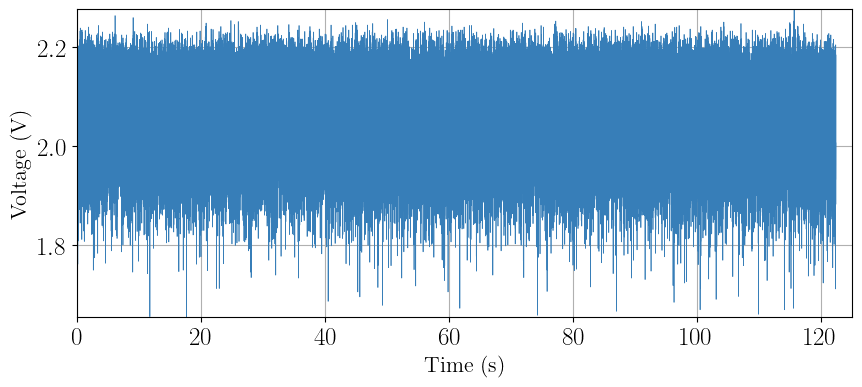

In [5]:
# Plot to visualise timeseries
max_x = 5*(np.floor_divide(np.max(time),5)+1)
fig1, ax = plt.subplots(figsize=(10, 4), dpi=dpi)
ax.plot(time, signal, alpha = 1, label='Voltage timeseries', linewidth=0.5, color=colours[1])
ax.set_xlim([0,max_x])
ax.set_ylim([np.min(signal)-0.0005,np.max(signal)+0.0005])
#ax.set_xticks(np.arange(0,max_x,5))
#ax.set_yticks(np.arange(np.min(signal),np.max(signal),0.005))
ax.set_ylabel(r'Voltage (V)', fontsize=16) 
ax.set_xlabel(r'Time (s)',fontsize=16)  # label the y axis
plt.grid(True)
fig1.savefig('voltage_timeseries.png', dpi=600,bbox_inches="tight")
plt.show() 


We need to convert this voltage timeseries to a velocity timeseries.

Let us write a calibration function to extract the calibration coefficients. In this example, I will fit the calibration data to a 3rd order polynomial. 

You are encouraged to try different polynomial orders and functions (King's law, modified King's Law, etc.)

In your final report, include an analysis of the goodness of fit.

In [6]:
# Define calibration points (stencil)
cal_vel = [0,3.967,6.142,8.348,10.514,12.759,15.944,18.013,21.267,26.708] # Velocity list in m/s
order = 3 # Order of polynomial function for calibration

def calibrate_poly(cal_vel, order):
    volt_avg = []  # Initialise voltage array
    for vel in cal_vel:
        buffer = np.loadtxt('Calib/'+str(vel)+'.txt')  # Load the voltage timeseires for each velocity 
        volt_avg.append(np.abs(np.mean(buffer)))               # Calculate time-averaged voltage value

    coeffs=np.polyfit(volt_avg,cal_vel,order)             # Fit to a polynomial of order "order"
    print('Calibration function is:'+str(coeffs[0])+'x^3 + '+str(coeffs[1])+'x^2 + '+str(coeffs[2])+'x + '+str(coeffs[3]))
    return(coeffs, volt_avg)

calib, volts = calibrate_poly(cal_vel, order)  # Perform a calibration fitting using the defined calibration function

Calibration function is:30.868851680454757x^3 + -125.00674442714032x^2 + 171.3039823085367x + -79.62220969506313


Let's plot the resulting calibration curve to evaluate the fit qualitatively:

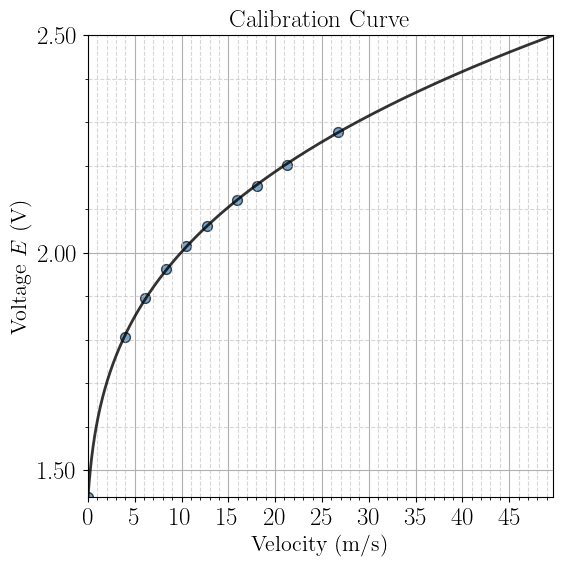

In [7]:
# Initialise a velocity vector to visualise calibration
voltsy=np.linspace(0,np.ceil(np.max(volts)/0.25)*0.25, 1000)
velx= np.polyval(calib, voltsy)

# Plot the calibration curve and calibration points
fig2, ax = plt.subplots(figsize=(6, 6), dpi=dpi)
ax.scatter(cal_vel, np.abs(volts), s=50, alpha=0.7, color=colours[1], edgecolors= "black")
ax.plot(velx, voltsy, alpha=0.8, linewidth=2, color="black")
ax.set_xlim([0,np.max(velx)])
ax.set_ylim([np.min(volts),np.max(voltsy)])
ax.set_xlabel(r'Velocity (m/s)', fontsize=16) 
ax.set_ylabel(r'Voltage $E$ (V)',fontsize=16)  
ax.set_title(r'Calibration Curve',fontsize=18)  
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_formatter(plt.NullFormatter())
ax.tick_params(axis="both", which="major")
plt.grid(True,  which='major')
plt.grid(True,  which='minor', linestyle='--', alpha=0.5)
fig2.savefig('calibration.png', dpi=600,bbox_inches="tight")
plt.show() 

What do you think of the obtained fit? How does it behave at low velocities where data points are sparse? How it does behave when extrapolated to velocities higher than the highest calibrated value? Do you see signs of over-fitting?

Exercise: Try fitting polynomials of various orders. Try fitting a physical model - King's Law/ Modified King's Law.

Let's have a quantitative estimate of the fitting operation by analysing the mean squared error:

In [8]:
# Evaluate the calibration function at the calibration points
model_vel = np.polyval(calib,volts)
# Evaluate the Mean Square Error (MSE)
MSE = np.square(np.subtract(cal_vel,model_vel)).mean()
print("Mean Square Error (MSE) = "+str(MSE)+" (m/s)^2")
print("This corresponds to an average velocity estimation error of "+str(np.round(np.sqrt(MSE),3))+" m/s due to the fitting")

Mean Square Error (MSE) = 0.006611742773294867 (m/s)^2
This corresponds to an average velocity estimation error of 0.081 m/s due to the fitting


Is this error acceptable? How does it compare to the velocity magnitudes for the intended measurement? How does this error compare to the error in obtaining the calibration velocities in the first place (error in velocity estimation from the Prandtl probe)?

Now that we have a set of calibration coefficients, we can convert our original acquired voltage timeseries into a velocity timeseries.

Note: If the voltage timeseries has been subjected to analog pre-amplification, we need to convert the amplified vvalues to calibration levels.

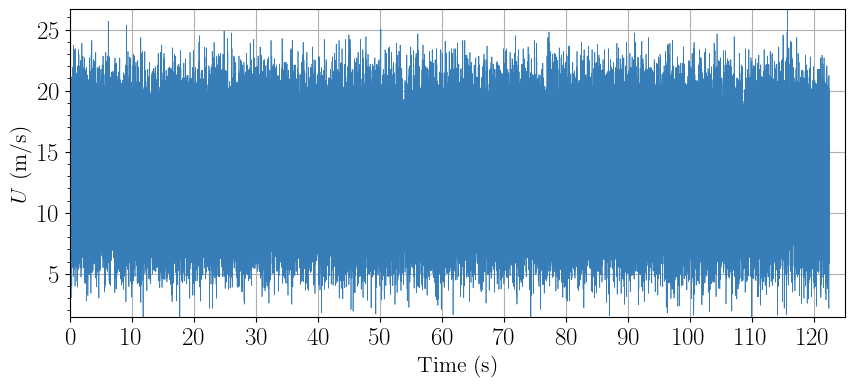

In [9]:
# Define amplification parameters 
gain = 1
offset = 0

# Convert the timeseries to calibration form
signal=(signal+offset)/gain

# Apply the calibration
U=np.polyval(calib,np.abs(signal))

# Plot the velocity timeseries
max_x = 5*(np.floor_divide(np.max(time),5)+1)
fig3, ax = plt.subplots(figsize=(10, 4), dpi=dpi)
ax.plot(time, U, alpha = 1, label='Voltage timeseries', linewidth=0.5, color=colours[1])
ax.set_xlim([0,max_x])
ax.set_ylim([np.min(U),np.max(U)])
ax.set_xticks(np.arange(0,max_x,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_formatter(plt.NullFormatter())
ax.set_ylabel(r'$U$ (m/s)', fontsize=16) 
ax.set_xlabel(r'Time (s)',fontsize=16)  # label the y axis
plt.grid(True)
fig3.savefig('velocity_timeseries.png', dpi=600,bbox_inches="tight")
plt.show() 

Now that we have a velocity timeseries, let's calculate the mean and standard deviation and re-plot the normalised timeseries.

Mean = 12.721 m/s
Std = 3.014 m/s


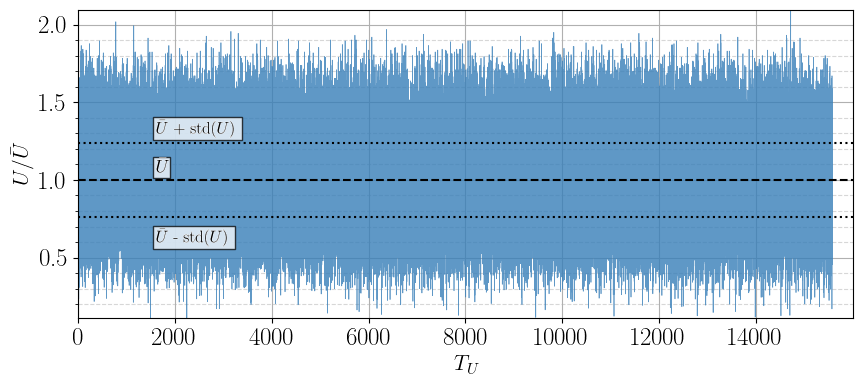

In [10]:
# Calculate mean and standard deviation
U_mean = np.mean(U)
U_std = np.std(U)

print("Mean = "+str(np.round(U_mean,3))+" m/s")
print("Std = "+str(np.round(U_std,3))+" m/s")

# Normalisation of velocity and time (Integeral time scale/Strouhal)
L=0.1 # Reference length scale
U_norm = U/U_mean # Normalised velocity
St=time*U_mean/L # Integral time scale

# Plot the velocity timeseries
max_x = 500*(np.floor_divide(np.max(St),500)+1)
fig4, ax = plt.subplots(figsize=(10, 4), dpi=dpi)
ax.plot(St, U_norm, alpha = 0.8, label='Voltage timeseries', linewidth=0.5, color=colours[1])
ax.set_xlim([0,max_x])
ax.set_ylim([np.min(U_norm),np.max(U_norm)])
ax.set_xticks(np.arange(0,max_x,2000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_formatter(plt.NullFormatter())
ax.axhline(y=1, color="black", linestyle="--")
text1 =ax.text(0.1*max_x, 1.05, r'$\bar{U}$', fontsize=13,transform=ax.transData,
    bbox={"facecolor": "white", "edgecolor": "black", "pad": 2, "alpha": 0.75} )
text1.set_path_effects([Stroke(linewidth=0.5, foreground="white"), Normal()])
ax.axhline(y=(U_mean+U_std)/U_mean, color="black", linestyle=":")
text2 =ax.text(0.1*max_x, 1.3, r'$\bar{U}$ + std($U$)', fontsize=12, transform=ax.transData,
    bbox={"facecolor": "white", "edgecolor": "black", "pad": 2, "alpha": 0.75})
text2.set_path_effects([Stroke(linewidth=0.5, foreground="white"), Normal()])
ax.axhline(y=(U_mean-U_std)/U_mean, color="black", linestyle=":")
text3 =ax.text(0.1*max_x, 0.6, r'$\bar{U}$ - std($U$)', fontsize=12, transform=ax.transData,
    bbox={"facecolor": "white", "edgecolor": "black", "pad": 2, "alpha": 0.75})
text3.set_path_effects([Stroke(linewidth=0.5, foreground="white"), Normal()])
ax.set_ylabel(r'$U/\bar{U}$', fontsize=16) 
ax.set_xlabel(r'$T_{U}$',fontsize=16)  
plt.grid(True)
plt.grid(True,  which='minor', linestyle='--', alpha=0.5)
fig4.savefig('normalised_timeseries.png', dpi=600,bbox_inches="tight")
plt.show() 

Visually check the range of "variability" of the signal and visually estimate the "turbulence level" i.e. ratio between amplitude of fluctations and mean value. Is it reasonable? 
Zoom in in the graph to see the details of the signal. Does it look "smooth"? 
Do you see any periodic components?

Let's plot a histogram of the samples to get a better idea of the distribution of velocity values:

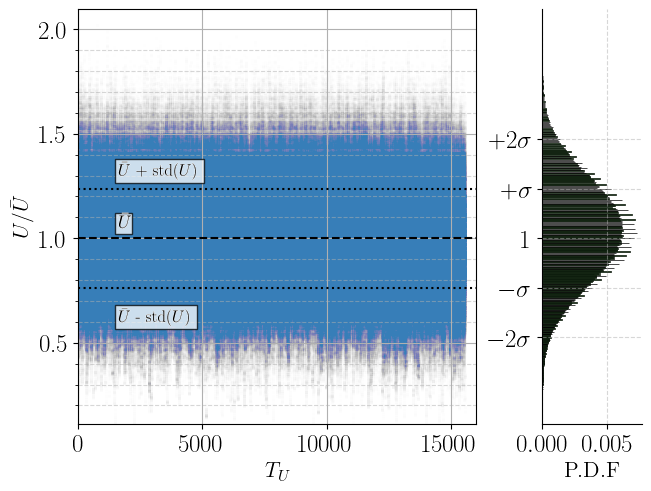

In [11]:
# Add histogram to plot

fig5 = plt.figure(constrained_layout=True)
nrows, ncols, ratio = 1, 2, 4
gspec = gridspec.GridSpec(
    ncols=ncols,
    nrows=nrows,
    figure=fig5,
    width_ratios=[ratio, 1],
)

ax = plt.subplot(gspec[0, 0])
#ax.plot(St, U_norm, alpha = 0.8, label='Voltage timeseries', linewidth=0.5, color=colours[1])
ax.scatter(St, U_norm, s=5, alpha=0.002, linewidth=0, color=colours[1], edgecolors= "black")
ax.set_xlim([0,max_x])
ax.set_ylim([np.min(U_norm),np.max(U_norm)])
ax.set_xticks(np.arange(0,max_x,5000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_formatter(plt.NullFormatter())
ax.axhline(y=1, color="black", linestyle="--")
text1 =ax.text(0.1*max_x, 1.05, r'$\bar{U}$', fontsize=13,transform=ax.transData,
    bbox={"facecolor": "white", "edgecolor": "black", "pad": 2, "alpha": 0.75} )
text1.set_path_effects([Stroke(linewidth=0.5, foreground="white"), Normal()])
ax.axhline(y=(U_mean+U_std)/U_mean, color="black", linestyle=":")
text2 =ax.text(0.1*max_x, 1.3, r'$\bar{U}$ + std($U$)', fontsize=12, transform=ax.transData,
    bbox={"facecolor": "white", "edgecolor": "black", "pad": 2, "alpha": 0.75})
text2.set_path_effects([Stroke(linewidth=0.5, foreground="white"), Normal()])
ax.axhline(y=(U_mean-U_std)/U_mean, color="black", linestyle=":")
text3 =ax.text(0.1*max_x, 0.6, r'$\bar{U}$ - std($U$)', fontsize=12, transform=ax.transData,
    bbox={"facecolor": "white", "edgecolor": "black", "pad": 2, "alpha": 0.75})
text3.set_path_effects([Stroke(linewidth=0.5, foreground="white"), Normal()])
ax.set_ylabel(r'$U/\bar{U}$', fontsize=16) 
ax.set_xlabel(r'$T_{U}$',fontsize=16)  
plt.grid(True)
plt.grid(True,  which='minor', linestyle='--', alpha=0.5)

ax = plt.subplot(gspec[0, 1])
ax.set_ylim([np.min(U_norm),np.max(U_norm)]), ax.set_yticks([(1-2*U_std/U_mean),(1-U_std/U_mean),1,(1+U_std/U_mean),(1+2*U_std/U_mean)])
ax.set_yticklabels([r'$-2\sigma$',r'$-\sigma$',r'$1$',r'$+\sigma$',r'$+2\sigma$']), ax.set_xticks([0,0.005])
ax.spines["right"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
H = ax.hist(
    U_norm,
    #bins=np.linspace(0, 1, 21),
    bins=1001,
    facecolor=colours[2],
    edgecolor="black",
    orientation="horizontal",
    weights=1/len(U_norm) * np.ones(len(U_norm)),
    #density=True,
    linewidth=0.5,
)
ax.set_xlabel(r'P.D.F',fontsize=16) 
plt.grid(True,  linestyle='--', alpha=0.5)

fig5.savefig('normalised_timeseries_hist.png', dpi=600,bbox_inches="tight")
plt.show() 

Does the histogram look smooth? What statistical distribution do you think will best fit the histogram? 

What about the statistical stationarity of the mean?

Let us examine the statistical stationarity by means of a "sliding average":


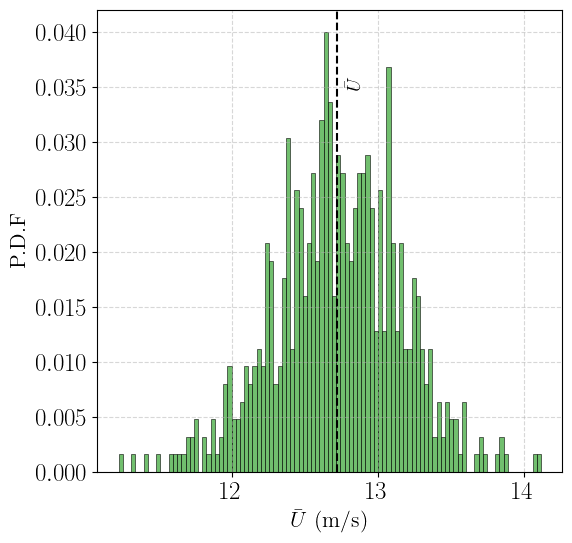

In [24]:
# Sliding average
samples_window = 10000 # Number of samples in each window
num_windows = int(np.floor(len(U)/samples_window)) # Number of windows to "cut" the signal

exp_vals=[]
for i in range(1,num_windows,1):
    exp_vals.append(np.mean(U[samples_window*(i-1):(samples_window*i)-1]))

fig6, ax = plt.subplots(figsize=(6, 6), dpi=dpi)
#ax.set_ylim([np.min(U_norm),np.max(U_norm)]), ax.set_yticks([(1-2*U_std/U_mean),(1-U_std/U_mean),1,(1+U_std/U_mean),(1+2*U_std/U_mean)])
#ax.set_yticklabels([r'$-2\sigma$',r'$-\sigma$',r'$1$',r'$+\sigma$',r'$+2\sigma$']), ax.set_xticks([0,0.005])
#ax.spines["right"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
#ax.spines["top"].set_visible(False)
H = ax.hist(
    exp_vals,
    #bins=np.linspace(0, 1, 21),
    bins=101,
    facecolor=colours[2],
    edgecolor="black",
    orientation="vertical",
    weights=1/len(exp_vals) * np.ones(len(exp_vals)),
    density=False,
    linewidth=0.5,
    alpha=0.8
)
ax.set_xlabel(r'$\bar{U}$ (m/s)',fontsize=16)
ax.set_ylabel(r'P.D.F',fontsize=16) 
plt.grid(True,  linestyle='--', alpha=0.5)
ax.axvline(x=U_mean, color="black", linestyle="--")
text1 =ax.text(1.005*U_mean, 0.035, r'$\bar{U}$', fontsize=14, rotation=90) 
fig6.savefig('sliding_avg_hist.png', dpi=600,bbox_inches="tight")
plt.show() 


Compute mean and variance of exp_vals and repeats the sliding average procedure above by changing the number of samples per window. 
What happends to mean and variance? What does it tells us about the statistical uncertainty? 

%%% 5.1 compute and plot the spectrum of the turbulent fluctuations using
%%% p-welch function Hint: vary the number of windows used in the welch method and see how the
%%% spectral estimate changes. Scale the  frequency vector by kolmogorov time-scales%%%%%%